In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Strain signal from a non-evolving binary

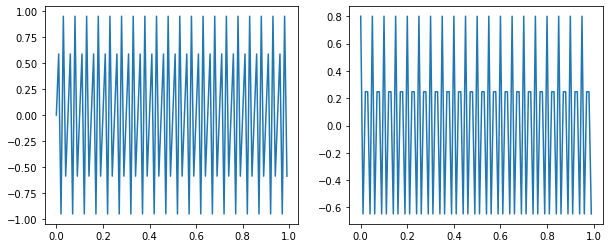

In [2]:
### Strain signal from a non-evolving binary

#parameters 
A = 1
B = 0.8
f0 = 40
phi0 = np.pi/2

### Nyquist theorem fs>f0
fs = 2.5*f0

t = np.arange(0, 1, 1/fs)

### waveforms
h_plus = A*np.sin(2*np.pi*f0*t)
h_cross = B*np.sin(2*np.pi*f0*t+phi0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(t, h_plus)
ax2.plot(t, h_cross)

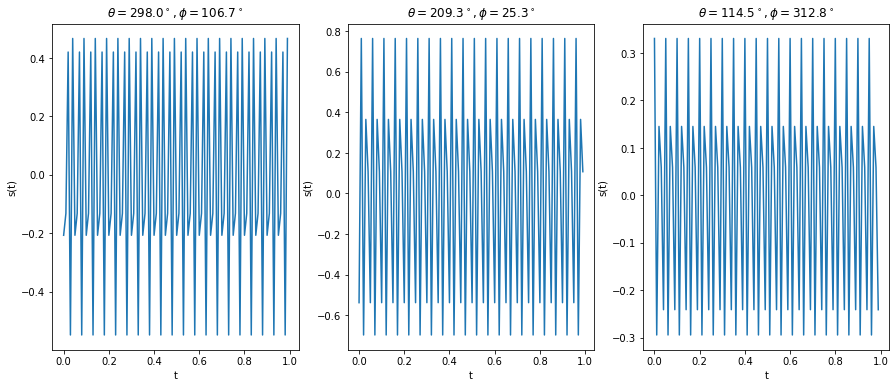

In [3]:
### Antenna response: L‐shaped interferometer

#### antenna pattern functions of the detector F_plus F_cross
#### strain signal s = F_plus*h_plus+F_cross*h_cross

def Antenna_response(h_plus, h_cross, theta, phi):
    F_plus = 1/2*(1+np.cos(theta)**2)*np.cos(2*phi)
    F_cross = np.cos(theta)*np.sin(2*phi)
    s = F_plus*h_plus+F_cross*h_cross
    return s


Ncase = 3
theta = np.random.uniform(0, 2*np.pi, Ncase)
phi = np.random.uniform(0, 2*np.pi, Ncase)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for theta_i, phi_i, ax_i in zip(theta, phi, ax):
    st = Antenna_response(h_plus, h_cross, theta_i, phi_i)
    ax_i.plot(t, st)
    ax_i.set_xlabel("t")
    ax_i.set_ylabel("s(t)")
    ax_i.set_title(r"$\theta={:.1f}^\circ, \phi={:.1f}^\circ$".format(theta_i*180/np.pi, phi_i*180/np.pi))



## Antenna patterns

![desc](lab2_1.jpg)

In [4]:
### wave frame tensor
def wave_frame_axes(theta, phi):
    wave_x = np.array([-np.sin(phi), np.cos(phi), 0])
    wave_y = np.array([-np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi), np.sin(theta)])
    return wave_x, wave_y

### polarization tensor
def polarization_tensor(wave_x, wave_y, psi):
    eplus_wave = np.einsum('i,j->ij', wave_x, wave_x)-np.einsum('i,j->ij', wave_y, wave_y)
    ecross_wave = np.einsum('i,j->ij', wave_x, wave_y)+np.einsum('i,j->ij', wave_y, wave_x)
    eplus = eplus_wave*np.cos(2*psi)+ecross_wave*np.sin(2*psi)
    ecross = -eplus_wave*np.sin(2*psi)+ecross_wave*np.cos(2*psi)
    return eplus, ecross


class SpaceInterferometer:
    def __init__(self, orbit):
        self.orbit = orbit

### detector direction
    def detector_direction(self, sp1, sp2, sp3):
        n1 = sp2-sp3
        n2 = sp1-sp2
        n3 = sp3-sp1
        return n1/np.linalg.norm(n1), n2/np.linalg.norm(n2), n3/np.linalg.norm(n3)

### Michelson TDI combinations
    def detector_tensor_TDI(self, t):
        sp1, sp2, sp3 = self.orbit(t)
        n1, n2, n3 = self.detector_direction(sp1, sp2, sp3)
        d1 = 0.5*(np.einsum('ai,aj->aij', n1, n1) -
                  np.einsum('ai,aj->aij', n2, n2))
        d2 = 1/(2*np.sqrt(3)) * (np.einsum('ai,aj->aij', n1, n1) +
                                 np.einsum('ai,aj->aij', n2, n2)-2*np.einsum('ai,aj->aij', n3, n3))
        return d1, d2

### antenna pattern
    def antenna_pattern(self, t, theta, phi, psi):
        d1, d2 = self.detector_tensor_TDI(t)
        wave_x, wave_y = wave_frame_axes(theta, phi)
        polar_tensor_plus, polar_tensor_cross = polarization_tensor(
            wave_x, wave_y, psi)
        Fplus1 = np.einsum('ij,aij->a', polar_tensor_plus, d1)
        Fplus2 = np.einsum('ij,aij->a', polar_tensor_cross, d2)
        Fcross1 = np.einsum('ij,aij->a', polar_tensor_cross, d1)
        Fcross2 = np.einsum('ij,aij->a', polar_tensor_plus, d2)
        return Fplus1, Fcross1, Fplus2, Fcross2

        return np.einsum('ai,i->a', center, wave_n)/c

    def response(self, hplus, hcross, t, theta, phi, psi, calc_time_delay=True):
        if calc_time_delay:
            t += self.time_delay(t, theta, phi)
        Fplus1, Fcross1, Fplus2, Fcross2 = self.antenna_pattern(t, theta, phi, psi)
        h1 = Fplus1*hplus+Fcross1*hcross
        h2 = Fplus2*hplus+Fcross2*hcross
        return h1, h2


### LISA orbit

In [5]:
def LISA_orbit(t: np.ndarray):
    # t unit: year
    R = 9973191.38 # km (UA) = distance to the Sun

    # Initial position of the 3 LISA spacecrafts
    Delta_phi = -np.pi/6
    L = R/3  # inter-spacecraft distance = arms' length in relative unit

    # Rotation matrix from (E,x,y,z) to (cdm,x,y,z)
    Mr0 = np.array([[np.cos(Delta_phi), -np.sin(Delta_phi), 0],
                    [np.sin(Delta_phi), np.cos(Delta_phi), 0],
                    [0, 0, 1]])

    Phi = 2*np.pi*t
    # circular path/trajectory modelling
    # Earth
    x_E = R*np.cos(Phi)  # anti-clockwise rotation way
    y_E = R*np.sin(Phi)
    z_E = np.zeros_like(x_E)
    E = np.array([x_E, y_E, z_E]).T

    # Rotation matrix from LISA plan (cdm,1,2,3) to (cdm,x-y-z) plan
    Mr2 = np.array([[np.cos(np.pi/3), 0, -np.sin(np.pi/3)],
                    [0, 1, 0],
                    [np.sin(np.pi/3), 0, np.cos(np.pi/3)]])

    # Rotation matrix from one LISA spacecraft to its following neighbour
    Mr3 = np.array([[np.cos(-2*np.pi/3), -np.sin(-2*np.pi/3), 0],
                    [np.sin(-2*np.pi/3), np.cos(-2*np.pi/3), 0],
                    [0, 0, 1]])

    # Initial spacecraft positions
    Sp1 = np.array([L/np.sqrt(3), 0, 0])  # in (E,x,y,z) base % top

    # Spacecraft trajectories
    Sp1path = np.zeros((3, len(E[0])))
    Mr5 = np.array([[np.cos(Phi), -np.sin(Phi), np.zeros_like(Phi)],
                    [np.sin(Phi), np.cos(Phi), np.zeros_like(Phi)],
                    [np.zeros_like(Phi), np.zeros_like(Phi), np.ones_like(Phi)]])
    Mr5 = np.transpose(Mr5, (2, 0, 1))

    # Rotation matrix of LISA triangle during one period
    Mr6 = Mr5*np.array([[1, -1, 1], [-1, 1, 1], [1, 1, 1]])
    Sp1path = Mr0@(E+Mr5@Mr2@Mr6@Sp1).T
    Sp2path = np.linalg.inv(Mr3)@Sp1path
    Sp3path = Mr3@Sp1path

    return Sp1path.T, Sp2path.T, Sp3path.T


### Toy LISA response: Partial

![desc](lab2_partial.jpg)

Text(0.5, 1.0, '$\\theta=330.5^\\circ\\ \\phi=295.9^\\circ\\ \\psi=199.2^\\circ$')

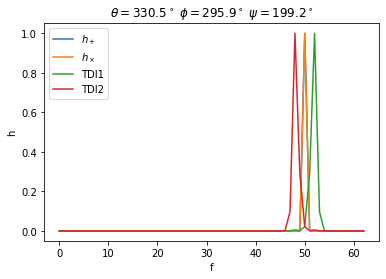

In [9]:
lisa = SpaceInterferometer(LISA_orbit)

A = 1
B = 1
f0 = 50
phi0 = np.pi/2

fs = 2.5*f0
t = np.arange(0, 1, 1/fs)
hplus = A*np.sin(2*np.pi*f0*t)
hcross = B*np.sin(2*np.pi*f0*t+phi0)

theta = np.random.uniform(0, 2*np.pi)
phi = np.random.uniform(0, 2*np.pi)
psi = np.random.uniform(0, 2*np.pi)

h1, h2 = lisa.response(hplus, hcross, t, theta, phi, psi, calc_time_delay=False)

f = np.fft.rfftfreq(len(t), 1/fs)
for signal, label in zip([hplus, hcross, h1, h2], ['$h_+$', '$h_\\times$', 'TDI1', 'TDI2']):
    signal_f = np.abs(np.fft.rfft(signal))
    plt.plot(f, signal_f/np.max(signal_f), label=label)
plt.legend()
plt.xlabel('f')
plt.ylabel('h')
plt.title(r'$\theta={:.1f}^\circ\ \phi={:.1f}^\circ\ \psi={:.1f}^\circ$'.format(theta*180/np.pi, phi*180/np.pi, psi*180/np.pi))